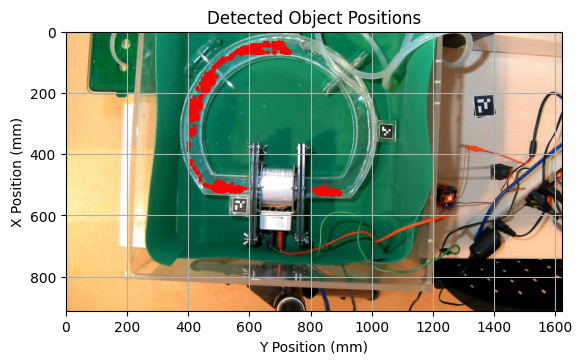

In [8]:
import json
import numpy as np
import cv2
import matplotlib.pyplot as plt
from datetime import datetime

# Load the image 
image = cv2.imread('blend_test.png')
# Load JSON data
path = 'Generated_data/Fish_data.json'
with open(path, 'r') as f:
    data = json.load(f)
# Filter data where 'detected' is true and 'centroid' exists
detected_data = [item['centroids'][0] for item in data if item.get('detected') and 'centroids' in item]
# Extract x and y positions
x_positions = [centroid[0] for centroid in detected_data]
y_positions = [centroid[1] for centroid in detected_data]

# Conversion factor from pixels to mm
conversion_factor = 38 / 45

# Convert positions from pixels to mm
x_positions_mm = [x * conversion_factor for x in x_positions]
y_positions_mm = [y * conversion_factor for y in y_positions]

# Resize the image to match the scale in mm
image_height, image_width = image.shape[:2]
scaled_width = int(image_width * conversion_factor)
scaled_height = int(image_height * conversion_factor)
scaled_image = cv2.resize(image, (scaled_width, scaled_height))

# Plot the scaled image
plt.imshow(cv2.cvtColor(scaled_image, cv2.COLOR_BGR2RGB))
# Plot x and y data on top of the image
plt.scatter(x_positions_mm, y_positions_mm, color='red', marker='.', s=10)  # s=10 adjusts the size of the markers
plt.xlabel('Y Position (mm)')
plt.ylabel('X Position (mm)')
plt.title('Detected Object Positions')
plt.grid(True)
plt.show()


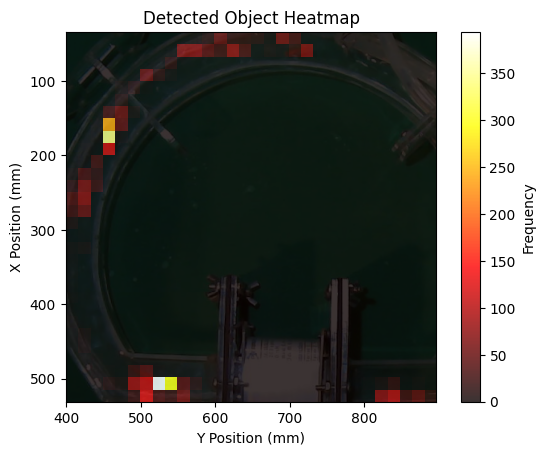

In [9]:
# Create a heatmap with positions in mm
heatmap, xedges, yedges = np.histogram2d(x_positions_mm, y_positions_mm, bins=30)

# Plot the scaled image
plt.imshow(cv2.cvtColor(scaled_image, cv2.COLOR_BGR2RGB))

# Plot the heatmap overlay
plt.imshow(heatmap.T, extent=[xedges[0], xedges[-1], yedges[-1], yedges[0]], alpha=0.8, cmap='hot')
plt.colorbar(label='Frequency')
plt.xlabel('Y Position (mm)')
plt.ylabel('X Position (mm)')
plt.title('Detected Object Heatmap')
plt.show()


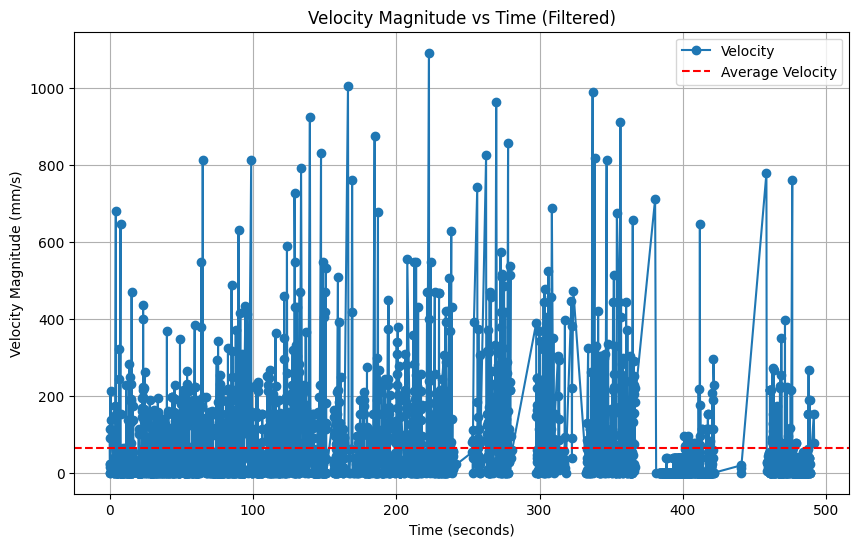

In [10]:
# Extract timestamps and velocities when detected
timestamps = []
velocities = []
for item in data:
    if item.get('detected') and 'velocity' in item:
        velocity = item['velocity']
        if len(velocity) == 2:  # Ensure there are two components in the velocity
            timestamps.append(item['timestamp'])
            velocities.append(velocity)

# Convert timestamps to datetime objects
time_format = '%Y-%m-%d %H:%M:%S:%f'
timestamps_dt = [datetime.strptime(timestamp, time_format) for timestamp in timestamps]

# Convert datetime objects to seconds relative to the first timestamp
start_time = timestamps_dt[0]
timestamps_in_seconds = [(timestamp - start_time).total_seconds() for timestamp in timestamps_dt]

# Convert velocity components from pixels/s to mm/s
velocities_mm = [[v[0] * conversion_factor, v[1] * conversion_factor] for v in velocities]

# Calculate the magnitude of the velocity vector in mm/s
vel_magnitudes_mm = [np.sqrt(velocity[0]**2 + velocity[1]**2) for velocity in velocities_mm]

# Filter out points where the velocity magnitude is greater than 1200 mm/s
filtered_timestamps_vel = []
filtered_velocities = []

for i in range(len(vel_magnitudes_mm)):
    if vel_magnitudes_mm[i] <= 1200:
        filtered_timestamps_vel.append(timestamps_in_seconds[i])
        filtered_velocities.append(vel_magnitudes_mm[i])

# Calculate the average velocity
average_velocity = np.mean(filtered_velocities)

# Plot velocity vs time and average line
plt.figure(figsize=(10, 6))
plt.plot(filtered_timestamps_vel, filtered_velocities, marker='o', label='Velocity')
plt.axhline(y=average_velocity, color='r', linestyle='--', label='Average Velocity')
plt.xlabel('Time (seconds)')
plt.ylabel('Velocity Magnitude (mm/s)')
plt.title('Velocity Magnitude vs Time (Filtered)')
plt.legend()
plt.grid(True)
plt.show()

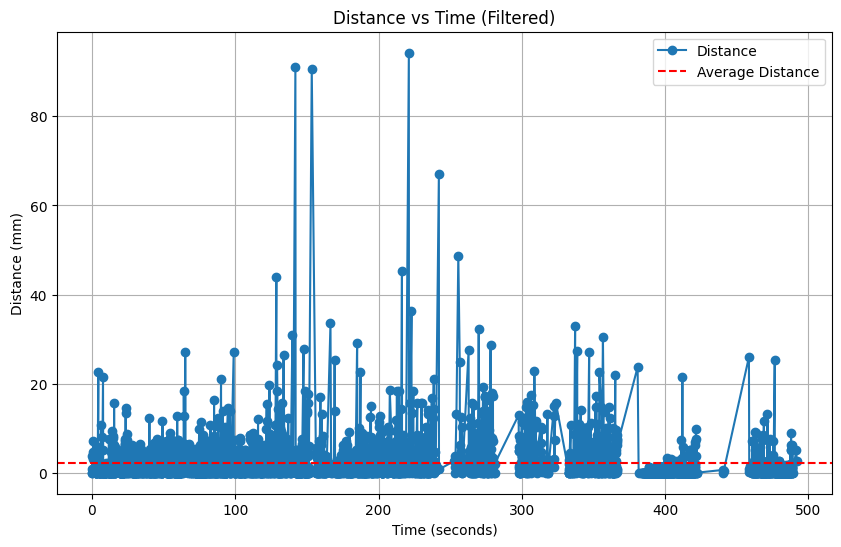

In [11]:
# Extract timestamps and distances when detected
timestamps = []
distances = []

for item in data:
    if item.get('detected') and 'distance' in item:
        timestamps.append(item['timestamp'])
        distances.append(item['distance'])

# Convert distances from pixels to mm
distances_mm = [distance * conversion_factor for distance in distances]

# Convert timestamps to datetime objects
time_format = '%Y-%m-%d %H:%M:%S:%f'
timestamps_dt = [datetime.strptime(timestamp, time_format) for timestamp in timestamps]

# Convert datetime objects to seconds relative to the first timestamp
start_time = timestamps_dt[0]
timestamps_in_seconds = [(timestamp - start_time).total_seconds() for timestamp in timestamps_dt]

# Filter out points where the delta between consecutive distances is greater than 50 mm
filtered_timestamps_dist = []
filtered_distances = []

for i in range(1, len(distances_mm)):
    if abs(distances_mm[i] - distances_mm[i-1]) <= 150:
        filtered_timestamps_dist.append(timestamps_in_seconds[i])
        filtered_distances.append(distances_mm[i])

# Calculate the average distance
average_distance = np.mean(filtered_distances)

# Plot distance vs time and average line
plt.figure(figsize=(10, 6))
plt.plot(filtered_timestamps_dist, filtered_distances, marker='o', label='Distance')
plt.axhline(y=average_distance, color='r', linestyle='--', label='Average Distance')
plt.xlabel('Time (seconds)')
plt.ylabel('Distance (mm)')
plt.title('Distance vs Time (Filtered)')
plt.legend()
plt.grid(True)
plt.show()

In [2]:
import json
import csv

# Load JSON data
path = 'Generated_data/Fish_data.json'
with open(path) as json_file:
    data = json.load(json_file)

# Determine the maximum number of detections in a single frame
max_detections = max(len(frame['centroids']) for frame in data)

# Generate column names based on the maximum number of detections
columns = ['frame_number', 'timestamp', 'video_timestamp']
for i in range(1, max_detections + 1):
    columns.extend([f'centroid x{i}', f'centroid y{i}', f'velocity x{i}', f'velocity y{i}', f'distance{i}'])

# Write to CSV
with open('Generated_data/fish_data.csv', 'w', newline='') as csv_file:
    writer = csv.DictWriter(csv_file, fieldnames=columns)
    writer.writeheader()

    for frame in data:
        row = {
            'frame_number': frame['frame_number'],
            'timestamp': frame['timestamp'],
            'video_timestamp': frame['video_timestamp'],
        }

        if frame['detected']:
            for i in range(max_detections):
                if i < len(frame['centroids']):
                    centroid = frame['centroids'][i]
                    velocity = frame['velocity'] if frame['velocity'] else [None, None]
                    row.update({
                        f'centroid x{i+1}': centroid[0],
                        f'centroid y{i+1}': centroid[1],
                        f'velocity x{i+1}': velocity[0],
                        f'velocity y{i+1}': velocity[1],
                        f'distance{i+1}': frame['distance']
                    })
                else:
                    row.update({
                        f'centroid x{i+1}': None,
                        f'centroid y{i+1}': None,
                        f'velocity x{i+1}': None,
                        f'velocity y{i+1}': None,
                        f'distance{i+1}': None
                    })
        else:
            for i in range(max_detections):
                row.update({
                    f'centroid x{i+1}': None,
                    f'centroid y{i+1}': None,
                    f'velocity x{i+1}': None,
                    f'velocity y{i+1}': None,
                    f'distance{i+1}': None
                })

        writer.writerow(row)

print("CSV file has been created successfully.")


CSV file has been created successfully.


In [3]:
import pandas as pd

# Load the CSV file
csv_file_path = 'Generated_data/fish_data.csv'
data = pd.read_csv(csv_file_path)

# Save the data to an Excel file
excel_file_path = 'Generated_data/fish_data.xlsx'
data.to_excel(excel_file_path, index=False)

excel_file_path

'Generated_data/fish_data.xlsx'